In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set(rc={'figure.figsize':(24, 15)}, font_scale=2)

import math

import sys
sys.path.append('../')
import utils
import synthetic_data_generator as sdg

from tqdm import tqdm
from glob import glob

Importing plotly failed. Interactive plots will not work.


# Generate multiple datasets

In [2]:
# Given a full time series, generate the base time series up to some timestamp t and simulate a streaming time series by generating a consecutively larger time series for every `delta` timestamps 
full_time_series_path = "../streaming_data/high_residual/consistent/df_full.pickle"
df_full = pd.read_pickle(full_time_series_path)
df_full = df_full.sort_values(by='time')

# Base length for the streaming timeseries 
base_time_series_size = int(len(df_full.index) / 4)
time_delta = 4
output_dir = '../streaming_data/high_residual/consistent/timeseries/'

# Generate the timeseries
for i in tqdm(range(base_time_series_size, len(df_full.index), time_delta)):
    df_tmp = df_full.head(i)
    df_tmp.to_pickle(output_dir+"df_"+str(i) + '.pickle')

100%|██████████| 945/945 [00:01<00:00, 607.26it/s]


# Evaluate Streaming Quality

In [3]:
regions_df = pd.read_pickle('../streaming_data/high_residual/consistent/regions_df.pickle')
df = pd.read_pickle('../streaming_data/high_residual/consistent/df_full.pickle')
df = df.sort_values(by='unix_time')

# Add unix time to the regions_df
regions_df['unix_start'] = df.loc[regions_df['start']]['unix_time'].values
regions_df['unix_end'] = df.loc[regions_df['end']]['unix_time'].values
regions_df

,region_id,start,end,length,unix_start,unix_end
0,0,516,539,24,1.592827e+09,1.592910e+09
1,1,965,988,24,1.594444e+09,1.594526e+09
2,2,1100,1123,24,1.594930e+09,1.595012e+09
3,3,1719,1742,24,1.597158e+09,1.597241e+09
4,4,2089,2112,24,1.598490e+09,1.598573e+09
5,5,3109,3132,24,1.602162e+09,1.602245e+09
6,6,3682,3705,24,1.604225e+09,1.604308e+09
7,7,3868,3891,24,1.604894e+09,1.604977e+09
8,8,4058,4081,24,1.605578e+09,1.605661e+09
9,9,4662,4685,24,1.607753e+09,1.607836e+09


In [4]:
# For each consecutive execution check the found clusters and if they make it into the top k
k = 3

# Get a list of all the diretories to loop through
dir_paths = glob("../streaming_data/high_residual/consistent/outputs/*/")
base_path = '../streaming_data/high_residual/consistent/outputs/df_1260/'
dir_paths.remove(base_path)
dir_paths.sort()

# Dataframe that corresponds to all the alerts that were sent out while streaming
alerts_df = pd.DataFrame(columns=['alert_time', 'cluster_start', 'alert_idx', 'cluster_start_idx'])

for dir_path in tqdm(dir_paths):
    clusters = pd.read_pickle(dir_path + 'clusters_df.pickle')
    clusters['rank'] = clusters['area'].rank(ascending=False)

    last_cluster_id = clusters['cluster_id'].max() 
    last_cluster_rank = clusters[clusters['cluster_id'] == last_cluster_id]['rank'].values[0]

    # Adjust k
    df = pd.read_pickle(dir_path + 'df.pickle')
    new_k = len(regions_df[regions_df['unix_start'] <= df['unix_time'].max()].index)
    if k != new_k:
        k=new_k
    
    # Check if last cluster makes it into the top-k
    if last_cluster_rank <= k:
        last_cluster_start = clusters[clusters['cluster_id'] == last_cluster_id]['start'].values[0]
        last_cluster_start_idx = df.iloc[(df['unix_time']-last_cluster_start).abs().argsort()[:1]].index.values[0]

        alert_time = df['unix_time'].max()
        if alerts_df.empty:
            alerts_df.loc[len(alerts_df.index)] = [alert_time, last_cluster_start, len(df.index), last_cluster_start_idx]
        else:
            # Check if there is already an alert after the current cluster_start
            latest_recorded_alert = alerts_df['alert_time'].max()
            if last_cluster_start > latest_recorded_alert:
                alerts_df.loc[len(alerts_df.index)] = [alert_time, last_cluster_start, len(df.index), last_cluster_start_idx]

alerts_df

100%|██████████| 944/944 [00:05<00:00, 162.15it/s]


,alert_time,cluster_start,alert_idx,cluster_start_idx
0,1.595718e+09,1.595203e+09,1320.0,1176.0
1,1.597028e+09,1.596233e+09,1684.0,1462.0
2,1.597316e+09,1.597037e+09,1764.0,1685.0
3,1.597936e+09,1.597407e+09,1936.0,1788.0
4,1.598569e+09,1.597948e+09,2112.0,1938.0
5,1.602227e+09,1.601815e+09,3128.0,3013.0
6,1.604315e+09,1.603930e+09,3708.0,3600.0
7,1.604963e+09,1.604543e+09,3888.0,3770.0
8,1.605654e+09,1.605202e+09,4080.0,3953.0
9,1.607843e+09,1.607573e+09,4688.0,4612.0


In [4]:
# Process alerts_df to check for accuracy and what region it corresponds to if it is correct
alerts_df['region_id_covered'] = np.nan
alerts_df['alert_in_region'] = False
for index, alert in alerts_df.iterrows():
    for _, region in regions_df.iterrows():
        # Check if the alert['alert_time'] happens during the interval of a true region
        if (alert['alert_time'] >= region['unix_start'] and alert['alert_time'] <= region['unix_end']):
            alerts_df.loc[index, 'alert_in_region'] = True

        # Check if there is a true region that has an overlap with the interval [row['cluster_start'], row['alert_time']]
        if (region['unix_start'] <= alert['cluster_start'] <= region['unix_end']) or (alert['cluster_start'] <= region['unix_start'] <= alert['alert_time']):
            alerts_df.loc[index, 'region_id_covered'] = region['region_id']

print("A total of", alerts_df['region_id_covered'].nunique(), 'alerts cover a true regions and', alerts_df['alert_in_region'].value_counts()[True], 'of them were alerted during a true region')
alerts_df

A total of 7 alerts cover a true regions and 4 of them were alerted during a true region


,alert_time,cluster_start,alert_idx,cluster_start_idx,region_id_covered,alert_in_region
0,1.595718e+09,1.595203e+09,1320.0,1176.0,NaN,False
1,1.597028e+09,1.596233e+09,1684.0,1462.0,NaN,False
2,1.597316e+09,1.597037e+09,1764.0,1685.0,3.0,False
3,1.597936e+09,1.597407e+09,1936.0,1788.0,NaN,False
4,1.598569e+09,1.597948e+09,2112.0,1938.0,4.0,True
5,1.602227e+09,1.601815e+09,3128.0,3013.0,5.0,True
6,1.604315e+09,1.603930e+09,3708.0,3600.0,6.0,False
7,1.604963e+09,1.604543e+09,3888.0,3770.0,7.0,True
8,1.605654e+09,1.605202e+09,4080.0,3953.0,8.0,True
9,1.607843e+09,1.607573e+09,4688.0,4612.0,9.0,False


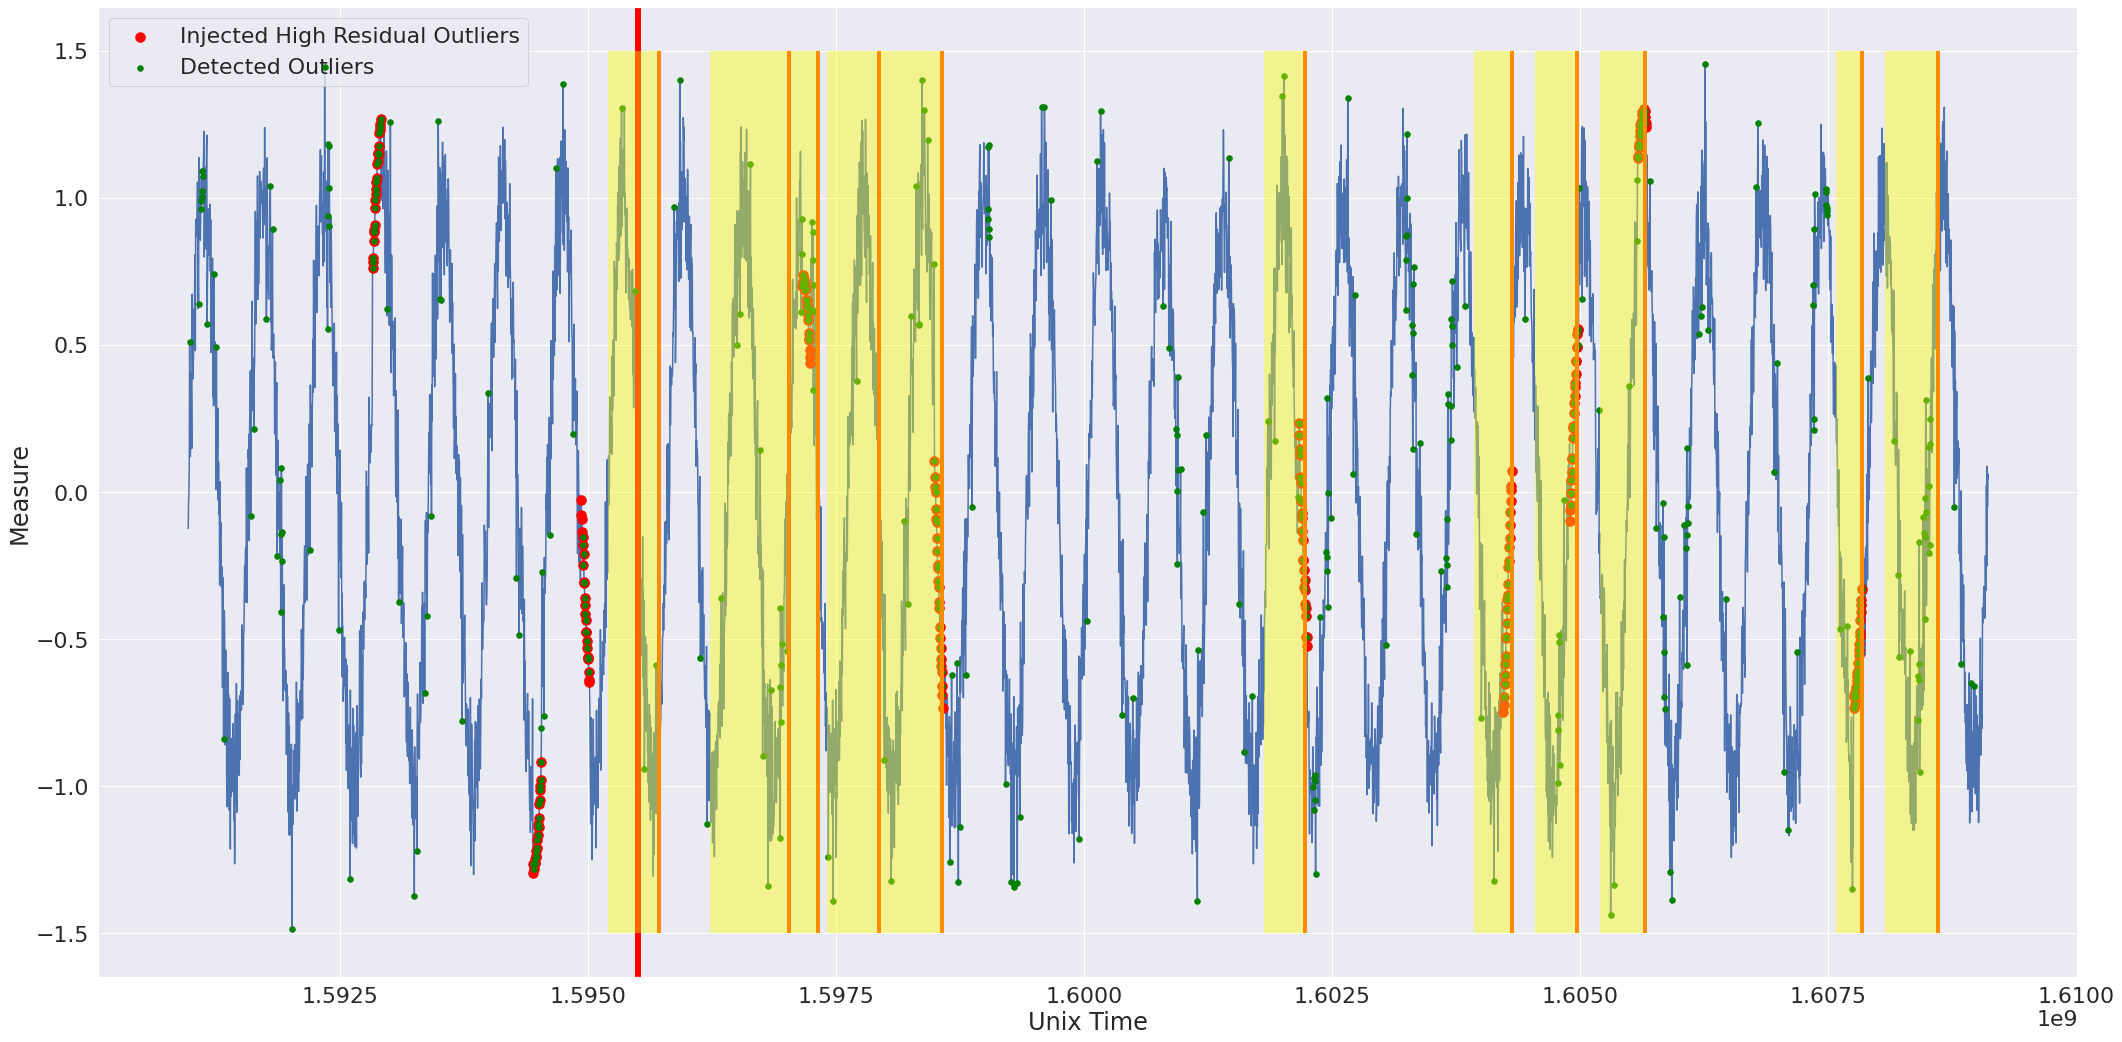

In [12]:
df = pd.read_pickle('../streaming_data/high_residual/consistent/df_full.pickle')
df = df.sort_values(by='unix_time')


fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (35,15)


plt.plot(df['unix_time'], df['measure'])
plt.scatter(df[df['outlier_type']=='high_residual']['unix_time'].values, df[df['outlier_type']=='high_residual']['measure'].values, s=90, c='red', zorder=10, label='Injected High Residual Outliers')
plt.scatter(df[df['raw_voting_score']>0]['unix_time'].values, df[df['raw_voting_score']>0]['measure'].values, s=30, c='green', zorder=10, label='Detected Outliers')


plt.vlines(alerts_df['alert_time'], ymin=-1.5, ymax=1.5, colors='darkorange', linewidth=4, zorder=100)

# Plot the alert regions
for _, alert in alerts_df.iterrows():
    ax.add_patch(patches.Rectangle((alert['cluster_start'], -1.5), width=alert['alert_time']-alert['cluster_start'], height=3, linewidth=0, color='yellow', zorder=10, alpha=0.40))

plt.axvline(df.loc[1260]['unix_time'], c='red', linewidth=6)

plt.ylabel('Measure');plt.xlabel('Unix Time');plt.legend();plt.tight_layout()
plt.savefig('../streaming_data/high_residual/consistent/full_series_with_alerts.svg')


# Testing

In [2]:
df = pd.read_pickle('../streaming_data/high_residual/consistent/outputs/df_1260/df.pickle')
df = df.sort_values(by='unix_time')
df

,time,timestamp,measure,signal,noise,is_outlier,outlier_type,region_id,yhat,yhat_lower,...,unix_time,cluster_id,start,end,point_start,point_end,time_length,num_points,area,area_pts
0,0.000000,2020-06-01 00:00:00,-0.123870,0.000000,-0.123870,0,NaN,NaN,0.009128,-0.316808,...,1.590970e+09,0.0,1.590970e+09,1.591505e+09,1.590984e+09,1.591456e+09,534916.750463,6,0.045065,0.040344
1,0.037407,2020-06-01 01:00:00,-0.040358,0.037344,-0.077703,0,NaN,NaN,0.047221,-0.267100,...,1.590973e+09,0.0,1.590970e+09,1.591505e+09,1.590984e+09,1.591456e+09,534916.750463,6,0.045065,0.040344
2,0.074815,2020-06-01 02:00:00,0.002411,0.074690,-0.072278,0,NaN,NaN,0.085250,-0.204107,...,1.590977e+09,0.0,1.590970e+09,1.591505e+09,1.590984e+09,1.591456e+09,534916.750463,6,0.045065,0.040344
3,0.112222,2020-06-01 03:00:00,0.080663,0.112182,-0.031519,0,NaN,NaN,0.123180,-0.190640,...,1.590980e+09,0.0,1.590970e+09,1.591505e+09,1.590984e+09,1.591456e+09,534916.750463,6,0.045065,0.040344
4,0.149629,2020-06-01 04:00:00,0.508700,0.151058,0.357641,1,noise,NaN,0.160971,-0.140065,...,1.590984e+09,0.0,1.590970e+09,1.591505e+09,1.590984e+09,1.591456e+09,534916.750463,6,0.045065,0.040344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,46.946205,2020-07-23 07:00:00,0.129813,0.175345,-0.045532,0,NaN,NaN,0.188377,-0.116725,...,1.595488e+09,8.0,1.595266e+09,1.595502e+09,1.595470e+09,1.595470e+09,236274.887536,1,0.005355,0.000000
1256,46.983612,2020-07-23 08:00:00,0.199892,0.140219,0.059674,0,NaN,NaN,0.155635,-0.138892,...,1.595491e+09,8.0,1.595266e+09,1.595502e+09,1.595470e+09,1.595470e+09,236274.887536,1,0.005355,0.000000
1257,47.021020,2020-07-23 09:00:00,-0.045212,0.103125,-0.148337,0,NaN,NaN,0.122803,-0.160387,...,1.595495e+09,8.0,1.595266e+09,1.595502e+09,1.595470e+09,1.595470e+09,236274.887536,1,0.005355,0.000000
1258,47.058427,2020-07-23 10:00:00,0.025740,0.065671,-0.039932,0,NaN,NaN,0.089891,-0.216447,...,1.595498e+09,8.0,1.595266e+09,1.595502e+09,1.595470e+09,1.595470e+09,236274.887536,1,0.005355,0.000000


In [3]:
density = pd.read_pickle('../streaming_data/high_residual/consistent/outputs/df_1260/density_df.pickle')
density['timestamp'] = pd.to_datetime(density['sample'], unit='s')
density

,sample,log_density,density,timestamp
0,1.590970e+09,-16.991721,4.174355e-08,2020-06-01 00:00:00.000000000
1,1.590971e+09,-16.986771,4.195071e-08,2020-06-01 00:19:59.364911318
2,1.590972e+09,-16.981937,4.215397e-08,2020-06-01 00:39:58.729822636
3,1.590973e+09,-16.977218,4.235335e-08,2020-06-01 00:59:58.094733953
4,1.590974e+09,-16.972613,4.254886e-08,2020-06-01 01:19:57.459645510
...,...,...,...,...
3775,1.595497e+09,-17.124205,3.656389e-08,2020-07-23 09:40:02.540354490
3776,1.595498e+09,-17.128736,3.639859e-08,2020-07-23 10:00:01.905266047
3777,1.595500e+09,-17.133460,3.622705e-08,2020-07-23 10:20:01.270177364
3778,1.595501e+09,-17.138376,3.604938e-08,2020-07-23 10:40:00.635088682


In [24]:
clusters = pd.read_pickle('../streaming_data/high_residual/consistent/outputs/df_5036/clusters_df.pickle')
starts = clusters.sort_values(by='area', ascending=False).head(10)['start'].values
ends = clusters.sort_values(by='area', ascending=False).head(10)['end'].values

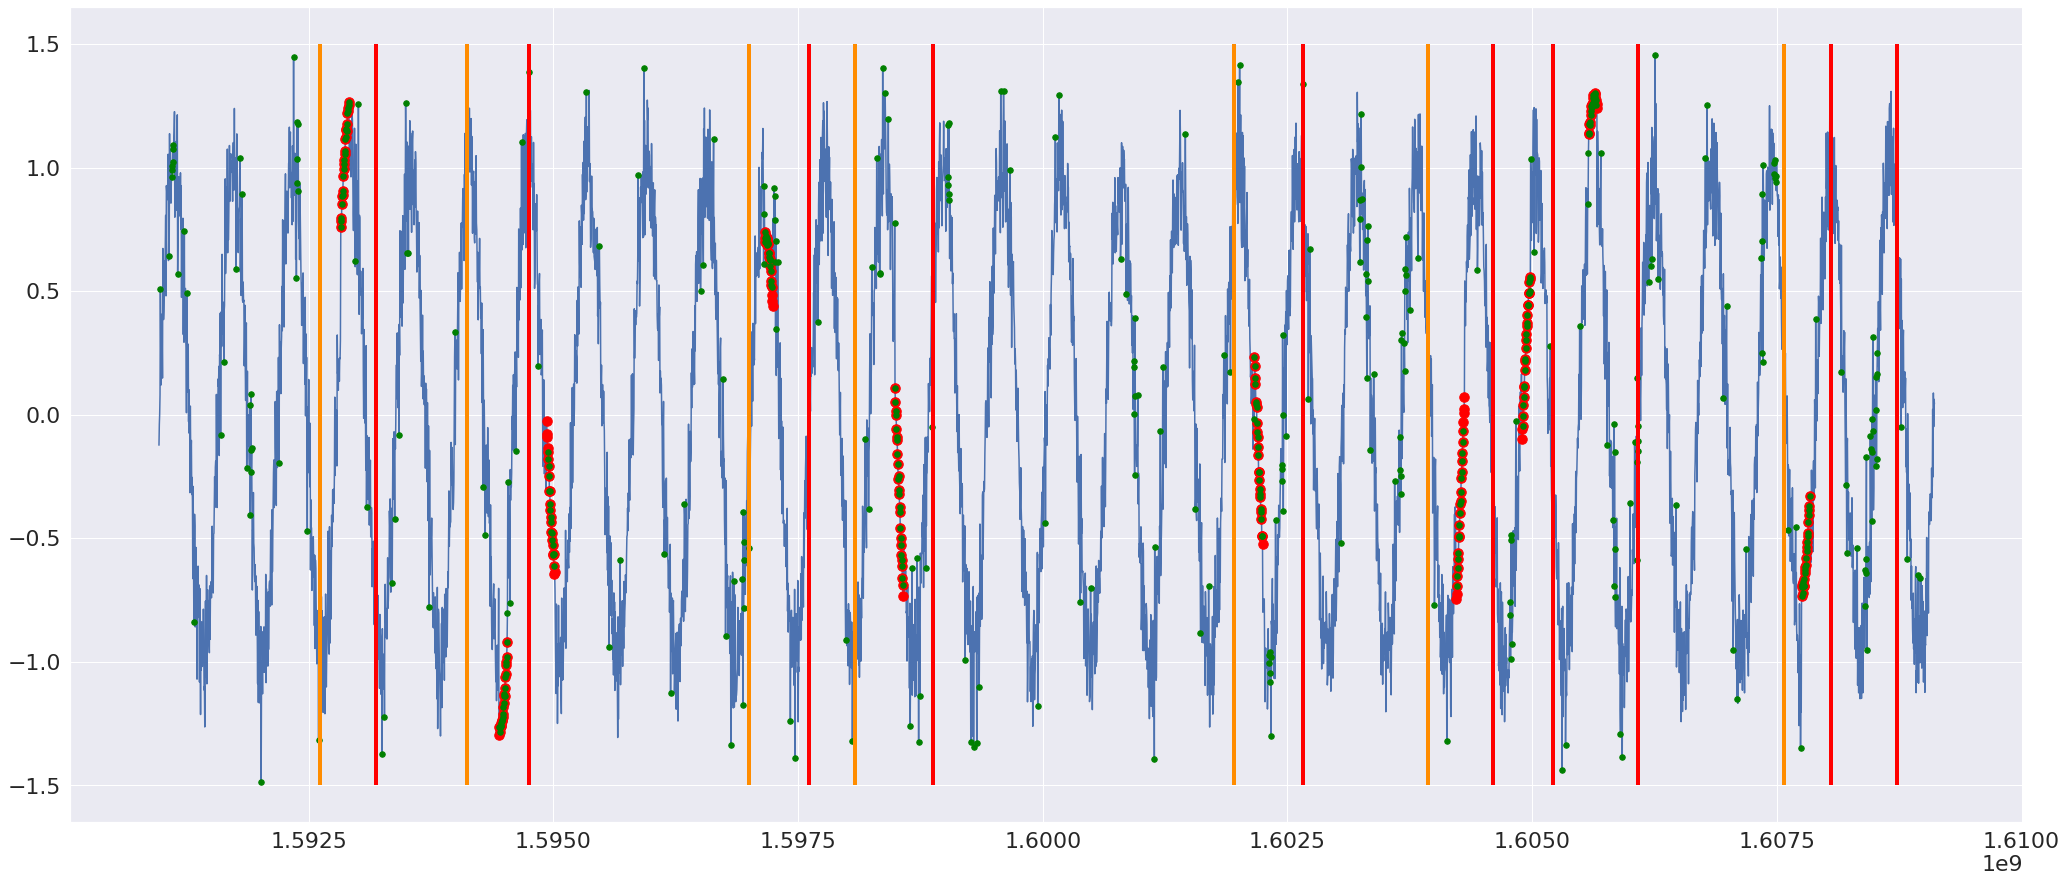

In [25]:
df = pd.read_pickle('../streaming_data/high_residual/consistent/df_full.pickle')
df = df.sort_values(by='unix_time')


fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (35,15)


plt.plot(df['unix_time'], df['measure'])
plt.scatter(df[df['outlier_type']=='high_residual']['unix_time'].values, df[df['outlier_type']=='high_residual']['measure'].values, s=90, c='red', zorder=10, label='Injected High Residual Outliers')
plt.scatter(df[df['raw_voting_score']>0]['unix_time'].values, df[df['raw_voting_score']>0]['measure'].values, s=30, c='green', zorder=10, label='Detected Outliers')

plt.vlines(starts, ymin=-1.5, ymax=1.5, colors='darkorange', linewidth=4, zorder=100)
plt.vlines(ends, ymin=-1.5, ymax=1.5, colors='red', linewidth=4, zorder=100)

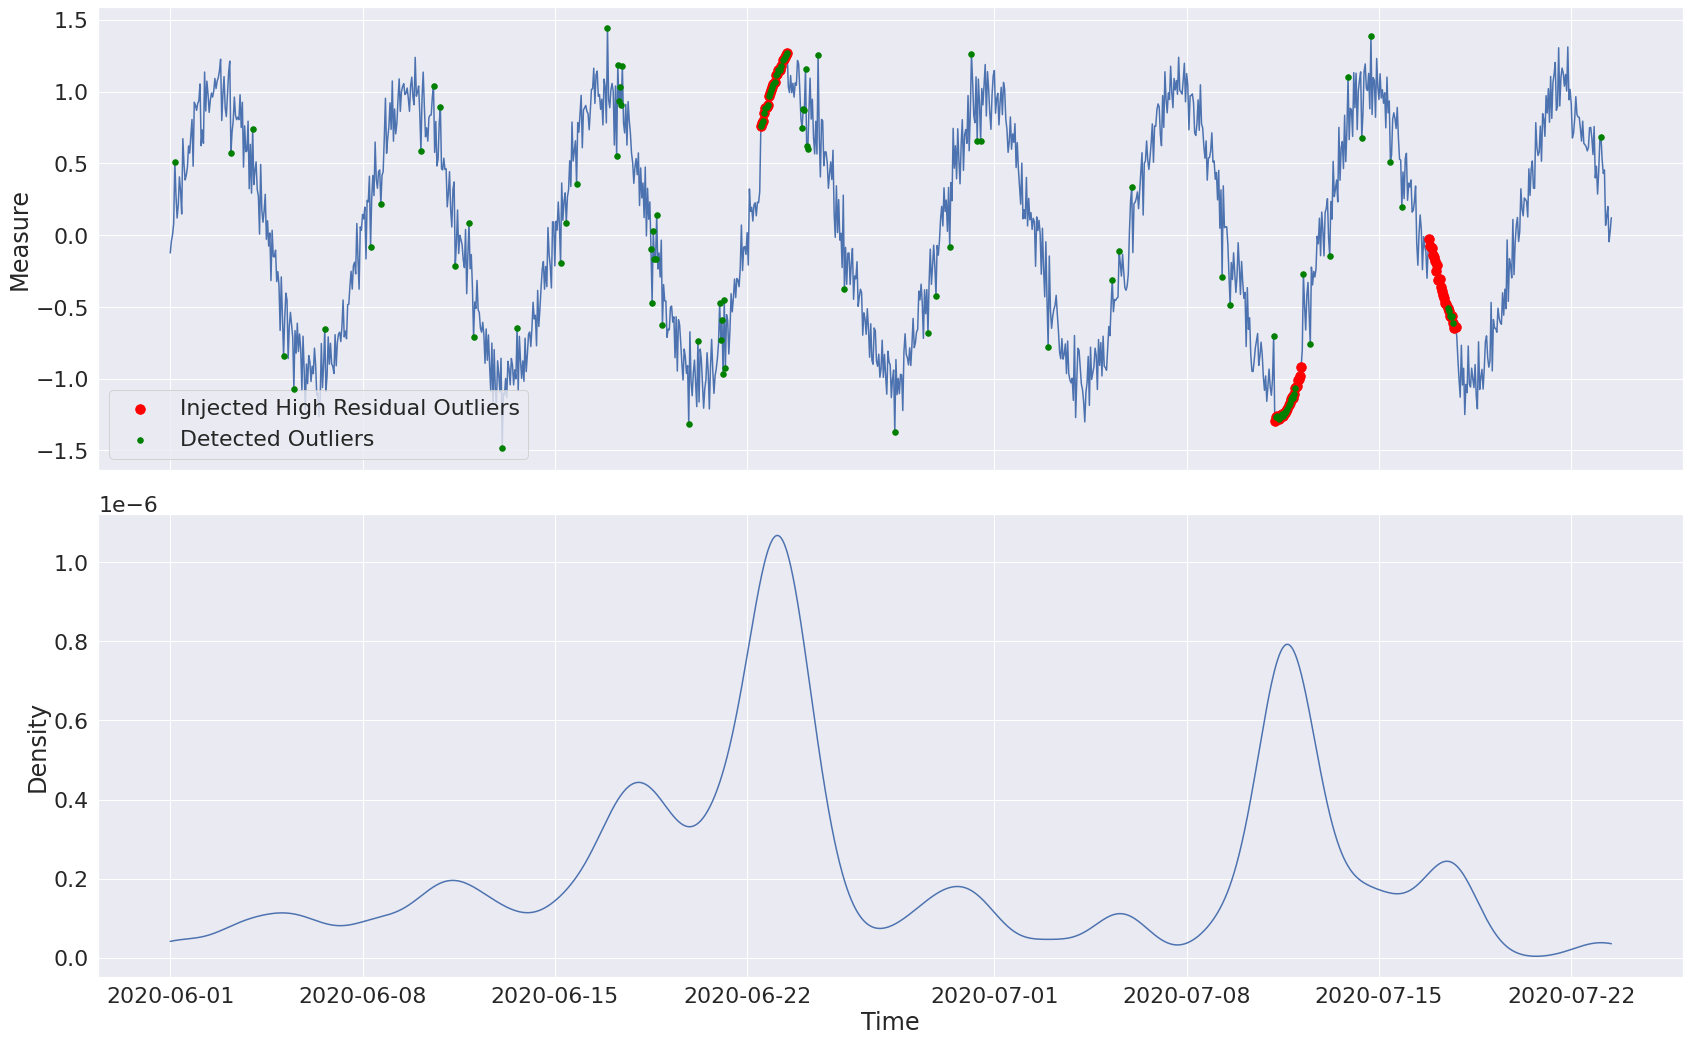

In [68]:
fig, axs = plt.subplots(2, sharex=True)
fig.subplots_adjust(hspace=0)

axs[0].plot(df['timestamp'], df['measure'])
axs[0].scatter(df[df['outlier_type']=='high_residual']['timestamp'].values, df[df['outlier_type']=='high_residual']['measure'].values, s=90, c='red', zorder=10, label='Injected High Residual Outliers')
axs[0].scatter(df[df['raw_voting_score']>0]['timestamp'].values, df[df['raw_voting_score']>0]['measure'].values, s=30, c='green', zorder=10, label='Detected Outliers')
axs[0].set_ylabel('Measure');axs[0].legend()

axs[1].plot(density['timestamp'], density['density'])
axs[1].set_ylabel('Density');axs[1].set_xlabel('Time')
plt.tight_layout()


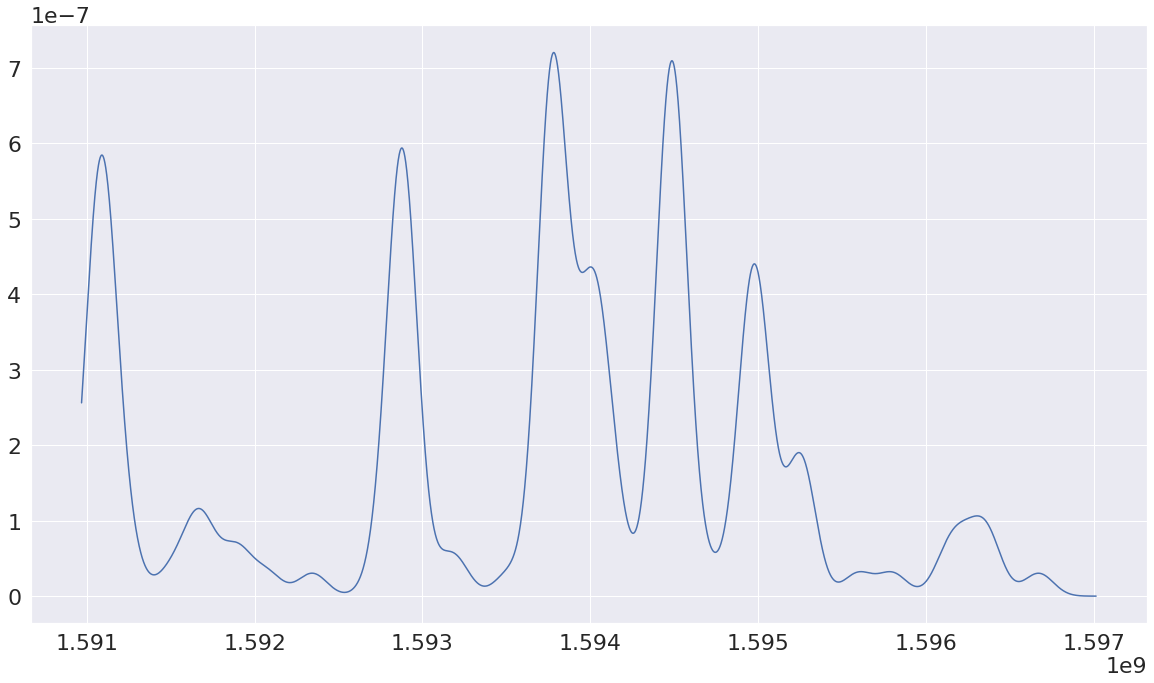

In [10]:
plt.plot(density['sample'], density['density'])

In [22]:
clusters = pd.read_pickle('../synthetic_data/high_residual/consistent/ma/regions_df.pickle')
clusters

,region_id,start,end,length
0,0,17,40,24
1,1,232,255,24
2,2,516,539,24
3,3,768,791,24
4,4,837,860,24
5,5,965,988,24
6,6,1100,1123,24
7,7,1719,1742,24
8,8,1874,1897,24
9,9,2089,2112,24


In [18]:
df = pd.read_pickle('../streaming_data/high_residual/consistent/df_full.pickle')
df = df.sort_values(by='time')
df

,time,timestamp,measure,signal,noise,is_outlier,outlier_type,region_id,yhat,yhat_lower,...,unix_time,cluster_id,start,end,point_start,point_end,time_length,num_points,area,area_pts
0,0.000000,2020-06-01 00:00:00,0.062298,0.000000e+00,0.062298,0,NaN,NaN,0.074406,-0.321747,...,1.590970e+09,0.0,1.590970e+09,1.591316e+09,1.591056e+09,1.591214e+09,346765.593531,13,0.015488,0.009406
1,0.037405,2020-06-01 01:00:00,0.036391,3.708525e-02,-0.000694,0,NaN,NaN,0.114434,-0.250926,...,1.590973e+09,0.0,1.590970e+09,1.591316e+09,1.591056e+09,1.591214e+09,346765.593531,13,0.015488,0.009406
2,0.074811,2020-06-01 02:00:00,-0.221091,7.528471e-02,-0.296376,0,NaN,NaN,0.154471,-0.236142,...,1.590977e+09,0.0,1.590970e+09,1.591316e+09,1.591056e+09,1.591214e+09,346765.593531,13,0.015488,0.009406
3,0.112216,2020-06-01 03:00:00,0.094538,1.110920e-01,-0.016554,0,NaN,NaN,0.194460,-0.172911,...,1.590980e+09,0.0,1.590970e+09,1.591316e+09,1.591056e+09,1.591214e+09,346765.593531,13,0.015488,0.009406
4,0.149622,2020-06-01 04:00:00,0.009331,1.524845e-01,-0.143154,0,NaN,NaN,0.234343,-0.156701,...,1.590984e+09,0.0,1.590970e+09,1.591316e+09,1.591056e+09,1.591214e+09,346765.593531,13,0.015488,0.009406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6715,251.177790,2021-03-07 19:00:00,-0.305529,-1.493348e-01,-0.156194,0,NaN,NaN,-0.122377,-0.509810,...,1.615144e+09,54.0,1.614452e+09,1.615158e+09,1.614622e+09,1.614938e+09,705529.996528,26,0.034244,0.023005
6716,251.215196,2021-03-07 20:00:00,-0.352417,-1.123108e-01,-0.240106,0,NaN,NaN,-0.083072,-0.437075,...,1.615147e+09,54.0,1.614452e+09,1.615158e+09,1.614622e+09,1.614938e+09,705529.996528,26,0.034244,0.023005
6717,251.252601,2021-03-07 21:00:00,-0.273483,-7.536297e-02,-0.198120,0,NaN,NaN,-0.043488,-0.432401,...,1.615151e+09,54.0,1.614452e+09,1.615158e+09,1.614622e+09,1.614938e+09,705529.996528,26,0.034244,0.023005
6718,251.290007,2021-03-07 22:00:00,0.151916,-3.704849e-02,0.188965,0,NaN,NaN,-0.003677,-0.363704,...,1.615154e+09,54.0,1.614452e+09,1.615158e+09,1.614622e+09,1.614938e+09,705529.996528,26,0.034244,0.023005
